In [ ]:
import os
import astropy.table

In [ ]:
CATSIM_CATALOG_PATH = "/sps/lsst/users/bbiswas/OneDegSq.fits"

_, ext = os.path.splitext(CATSIM_CATALOG_PATH)
fmt = "fits" if ext.lower() == ".fits" else "ascii.basic"
catalog = astropy.table.Table.read(CATSIM_CATALOG_PATH, format=fmt)

In [ ]:
catalog

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2200871446,0.418319702147,-0.000148399994941,0.496377289295,0.0,1.4144730572e-17,0.0,0.0,0.278649687767,0.0,0.221303001046,0.0,307.344329834,25.9418621063,25.129743576,23.9588813782,23.3607368469,23.0723800659,22.9095973969
2205921112,0.420028448104,-0.00100259995088,1.89508104324,0.0,1.91501907101e-18,0.0,0.0,0.358063697815,0.0,0.313674807549,0.0,137.791702271,25.848903656,25.867565155,25.9179477692,25.9851398468,25.8779563904,25.7642536163
2205010878,0.423432350157,-0.00312969996594,1.93795013428,0.0,2.15612608955e-18,0.0,0.0,0.444279909134,0.0,0.424689114094,0.0,233.972427368,25.5657653809,25.5659580231,25.6165962219,25.6957893372,25.6281528473,25.5399188995
2208734677,0.42108619213,-7.25999998394e-05,1.16251754761,0.0,1.74001598433e-18,0.0,0.0,0.312852591276,0.0,0.180962398648,0.0,217.517120361,27.3159255981,27.4167633057,27.051820755,26.6737632751,25.9380722046,25.6458129883
2212241881,0.423181056976,-0.00218109996058,1.35479903221,0.0,1.11031595423e-18,0.0,0.0,0.414316505194,0.0,0.205554202199,0.0,226.523849487,27.3325939178,27.4470024109,27.3282527924,27.0680370331,26.7419490814,26.1817016602
2204477290,0.422583341599,-0.000604000000749,1.33114361763,0.0,5.75775484903e-18,0.0,0.0,0.351797997952,0.0,0.126827403903,0.0,53.955165863,25.6527175903,25.7753200531,25.4755821228,25.2793464661,24.9572029114,24.4631252289
2201104165,0.422105312347,-0.00160690001212,0.812159895897,6.57883086866e-18,2.26453001134e-17,0.0,0.22702370584,0.191140606999,0.20540009439,0.0433686003089,24.3779182434,24.3779182434,25.9493045807,25.4186573029,24.5099773407,23.527223587,23.0481529236,22.813867569
2211831084,0.422278761862,-0.00242089992389,1.52316868305,0.0,1.06012697736e-18,0.0,0.0,0.216705903411,0.0,0.123286098242,0.0,13.71824646,27.2072696686,27.268491745,27.2910671234,27.0573310852,26.8970832825,26.4211711884
2213920571,0.428705215453,-0.00933680031449,1.01047706604,0.0,2.24895700248e-19,0.0,0.0,0.229738906026,0.0,0.175429001451,0.0,281.466491699,26.6581230164,26.9268531799,27.170211792,27.3262882233,27.3432483673,27.5143566132


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from galcheat.utilities import mag2counts, mean_sky_level
import numpy as np

# Compute SNR

(0.0, 2.0)

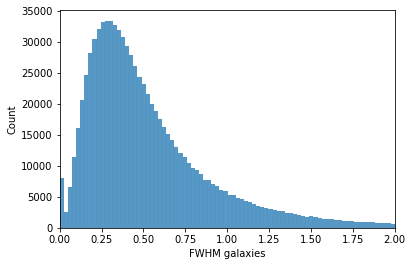

In [ ]:
ax = sns.histplot(2* np.sqrt(catalog["a_d"]*catalog["b_d"]), bins=2000)
ax.set_xlabel("FWHM galaxies")
ax.set_xlim((0,2))

In [ ]:
snr = []

# For calculation of source counts (C) and mean_sky_level (B) refer to https://github.com/aboucaud/galcheat/blob/main/galcheat/utilities.py
# For Computaion of SNR, refer to: https://smtn-002.lsst.io/

B = mean_sky_level("LSST", "r").to_value("electron")
sig_instr = 12.7
#n_eff = 2.266*((.83/.2)**2)
# Assume gain = 1 

for row in catalog:
    #print(row['r_ab'])
    
    # FWHM of galaxy
    FWHM_row = np.sqrt(row["a_d"]*row["b_d"])
    
    # convolve with FWHM of PSF
    FWHM = np.sqrt(FWHM_row**2 + .83**2)
    
    # compute n_eff
    n_eff = 2.266*((FWHM/.2)**2)

    C = mag2counts(row['r_ab'], "LSST", "r").to_value("electron") # is this correct?
    snr.append(C / np.sqrt(C + ( B + sig_instr**2 ) * n_eff))

In [ ]:
snr = np.array(snr)

### Plot distribution of SNR

Text(0.5, 0, 'SNR')

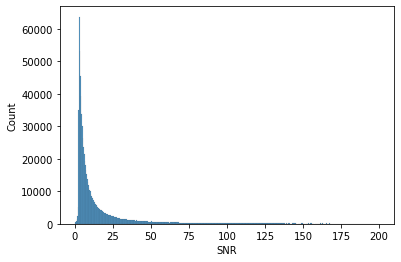

In [ ]:
sns.histplot(snr[snr<=200], bins=500);
plt.xlabel("SNR")

Text(0.5, 0, 'SNR')

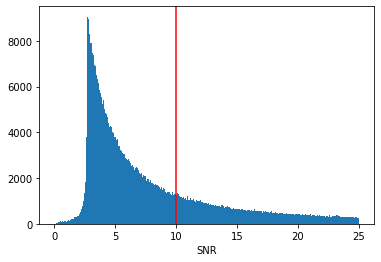

In [ ]:
plt.hist(snr[snr<=25], bins=500);
plt.axvline(10, color='r')
plt.xlabel("SNR")

In [ ]:
import seaborn as sns

Text(0, 0.5, 'mag')

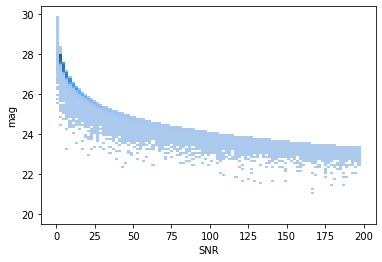

In [ ]:
x_bins = np.arange(0,200, 200/100.0)
y_bins = np.arange(20, 30, 10/100.0)

ax = sns.histplot(x=snr, y=catalog["r_ab"], bins=[x_bins, y_bins], kde=True)

ax.set_xlabel("SNR")
ax.set_ylabel("mag")

In [ ]:
catalog["r_band_snr"] = snr

<AxesSubplot:xlabel='r_ab', ylabel='r_band_snr'>

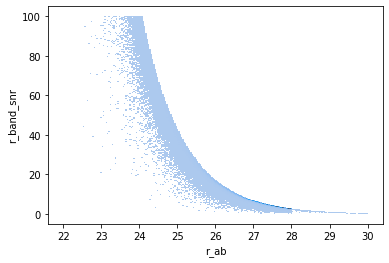

In [ ]:
sns.histplot(data=catalog.to_pandas(), x="r_ab", y="r_band_snr", binrange=[(22, 30), (0,100)])

In [ ]:
frac = np.sum(snr<5)/len(snr)*100
print(f"Percentage below snr 5 : {frac}")

Percentage below snr 5 : 34.49892953074076


### Isolate snr 10 datalog 

In [ ]:
snr_10_cat = catalog[snr>=10]

(10, 1000)

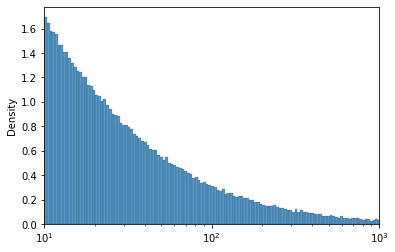

In [ ]:
ax = sns.histplot(snr_10_cat["r_band_snr"], log_scale=[True, False], stat="density")
ax.set_xlim(10,1000)

<AxesSubplot:ylabel='Density'>

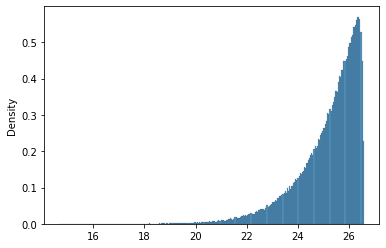

In [ ]:
sns.histplot(snr_10_cat["r_ab"], stat="density")

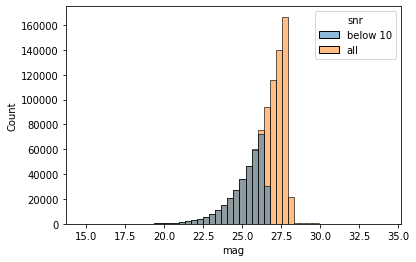

In [ ]:
import pandas as pd
sns_mag_df = {}

sns_mag_df["mag"] = list(snr_10_cat["r_ab"])
sns_mag_df["snr"] = ["below 10"]*len(snr_10_cat)

sns_mag_df["mag"].extend(list(catalog["r_ab"]))
sns_mag_df["snr"].extend(["all"]*len(catalog))

sns_mag_df = pd.DataFrame(sns_mag_df)

bins = sns.histplot(data=sns_mag_df, x="mag", hue="snr", bins=50, alpha=.5)
#sns.(catalog["i_ab"], bins=bins[1], alpha=.5)

In [ ]:
len(snr_10_cat)

346754

In [ ]:
# snr_10_cat.write("/sps/lsst/users/bbiswas/OneDegSq_snr_10.fits", overwrite=True)

<AxesSubplot:xlabel='r_ab', ylabel='r_band_snr'>

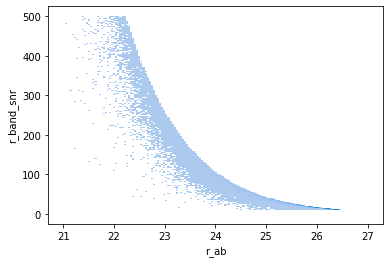

In [ ]:
sns.histplot(data=snr_10_cat.to_pandas(), x="r_ab", y="r_band_snr", binrange=[(21, 27), (0,500)])

In [ ]:
snr_10_cat['log_snr'] = np.log10(snr_10_cat['r_band_snr'])

<AxesSubplot:ylabel='Count'>

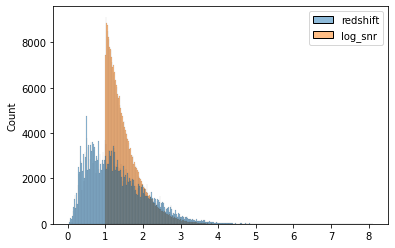

In [ ]:
sns.histplot(snr_10_cat['redshift', 'log_snr'].to_pandas())

<AxesSubplot:xlabel='redshift', ylabel='log_snr'>

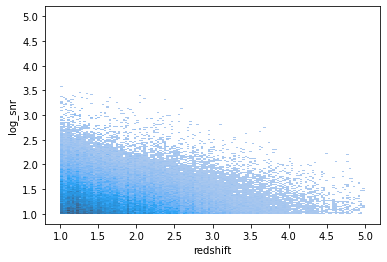

In [ ]:
sns.histplot(data=snr_10_cat.to_pandas(), x="redshift", y="log_snr", binrange=[(1, 5), (1,5)])

In [ ]:
snr_10_cat

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,r_band_snr,log_snr
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2200871446,0.418319702147,-0.000148399994941,0.496377289295,0.0,1.4144730572e-17,0.0,0.0,0.278649687767,0.0,0.221303001046,0.0,307.344329834,25.9418621063,25.129743576,23.9588813782,23.3607368469,23.0723800659,22.9095973969,105.19524568456008,2.0219961122548025
2205921112,0.420028448104,-0.00100259995088,1.89508104324,0.0,1.91501907101e-18,0.0,0.0,0.358063697815,0.0,0.313674807549,0.0,137.791702271,25.848903656,25.867565155,25.9179477692,25.9851398468,25.8779563904,25.7642536163,17.078772469361475,1.2324566527147687
2205010878,0.423432350157,-0.00312969996594,1.93795013428,0.0,2.15612608955e-18,0.0,0.0,0.444279909134,0.0,0.424689114094,0.0,233.972427368,25.5657653809,25.5659580231,25.6165962219,25.6957893372,25.6281528473,25.5399188995,21.523775914577318,1.332918461930062
2204477290,0.422583341599,-0.000604000000749,1.33114361763,0.0,5.75775484903e-18,0.0,0.0,0.351797997952,0.0,0.126827403903,0.0,53.955165863,25.6527175903,25.7753200531,25.4755821228,25.2793464661,24.9572029114,24.4631252289,26.766803867974787,1.4275965166717823
2201104165,0.422105312347,-0.00160690001212,0.812159895897,6.57883086866e-18,2.26453001134e-17,0.0,0.22702370584,0.191140606999,0.20540009439,0.0433686003089,24.3779182434,24.3779182434,25.9493045807,25.4186573029,24.5099773407,23.527223587,23.0481529236,22.813867569,66.21877150309436,1.8209811194185237
2205029524,0.426759123802,-0.00588729977608,2.62337517738,1.76236800714e-19,4.00829308249e-18,0.0,0.310758501291,0.353145509958,0.297534286976,0.163112699986,192.710525513,192.710525513,26.6237487793,25.6349658966,25.4367675781,25.620885849,25.5596847534,25.3557510376,27.495765969719763,1.4392658226463404
2205796354,0.428714990615,-0.00757079990581,0.748833298683,0.0,1.2929780096e-18,0.0,0.0,0.506412088871,0.0,0.406899303198,0.0,358.394989014,25.8366546631,25.9559650421,26.0390605927,25.79139328,25.7958583832,25.7776908875,14.464208345281536,1.1602946688388676
2205780198,0.425186038016,-0.00684770010412,2.73673796654,2.36539905575e-20,1.71083698143e-18,0.0,0.0929801985621,0.651051819324,0.0813373029232,0.228484198451,349.739440918,349.739440918,26.6940460205,25.7389945984,25.4774112701,25.7938842773,25.8609008789,25.6114196777,25.023917949598914,1.3983553073829968
2204160733,0.426273226737,-0.00803610030562,0.883550703526,0.0,2.79284505734e-18,0.0,0.0,0.282541513443,0.0,0.142981693149,0.0,66.6810913086,26.5272636414,26.4191303253,26.1512069702,25.3752822876,25.1441688538,25.1374740601,14.446281950949054,1.1597560868184993


<AxesSubplot:xlabel='redshift', ylabel='fluxnorm_disk'>

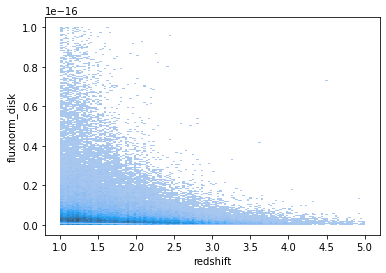

In [ ]:
sns.histplot(data=snr_10_cat.to_pandas(), x="redshift", y="fluxnorm_disk", binrange=[(1, 5), (0,1e-16)])

<AxesSubplot:xlabel='a_d', ylabel='fluxnorm_disk'>

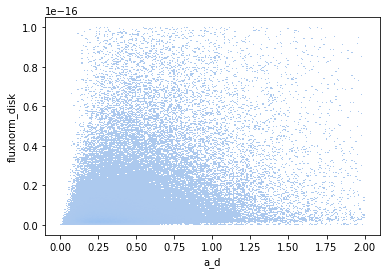

In [ ]:
sns.histplot(data=snr_10_cat.to_pandas(), x="a_d", y="fluxnorm_disk", binrange=[(0, 2), (0,1e-16)])

<AxesSubplot:xlabel='a_d', ylabel='b_d'>

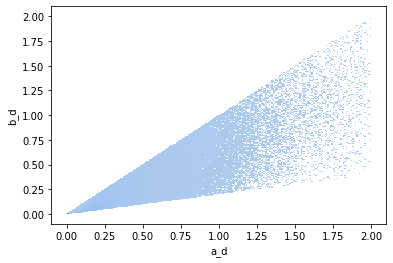

In [ ]:
sns.histplot(data=snr_10_cat.to_pandas(), x="a_d", y="b_d", binrange=[(0, 2), (0,2)])